In [1]:
from copy import deepcopy
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.datasets import make_regression, load_diabetes, fetch_california_housing
from sklearn import preprocessing
from sklearn.utils import resample
from tensorflow import keras
from tensorflow.keras import layers
import time
from tqdm import tqdm
import torch

/Users/shamsi/anaconda3/envs/hetfl/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-05-16 19:02:35.276460: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data

Experiments are performed on a synthetic dataset whose empirical graph $\mathcal {G}$ is partitioned into 3 equal-sized clusters $\mathcal{P} = \{\mathcal{C}^{(1)}, \mathcal{C}^{(2)}, \mathcal{C}^{(3)}\}$, with $|\mathcal{C}^{(1)}|=|\mathcal{C}^{(2)}|=|\mathcal{C}^{(3)}|$. We denote the cluster assignment of node $i \in \mathcal{V}$ by ${c}^{(i)} \in \{0,1,2\}$. 

Each node $i \in \mathcal {V}$ of the empirical graph $\mathcal {G}$ holds a local dataset $\mathcal {D}^{(i)}$ of the form $\mathcal {D}^{(i)} := \{ ({x}^{(i,1)}, {y}^{(i,1)}), ..., ({x}^{(i,{m}_{i})}, {y}^{(i,{m}_{i})}) \}$. Thus, dataset $\mathcal {D}_{(i)}$ consist of ${m}_{i}$ data points, each characterized by a feature vector $\mathbf{x}^{(i,r)} \in \mathbb{R}^{d}$ and scalar label ${y}^{(i,r)}$, for $r=1,...,{m}_{i}$. The feature vectors $\mathbf{x}^{(i,r)} \sim \mathcal{N}(\mathbf{0},\mathbf{I}_{d \times d})$, are drawn i.i.d. from a standard multivariate normal distribution. 

The labels of the data points are generated by a noisy linear model
\begin{equation}
{y}^{(i,r)} = (\mathbf{w}^{(i)})^T\mathbf{x}^{(i,r)} + {\varepsilon}^{(i,r)}
\end{equation}

The noise ${\varepsilon}^{(i,r)} \sim \mathcal{N}(0, {\sigma}^{2})$, for $i \in \mathcal{V}$ and $r=1,..,{m}_{i}$, are i.i.d. realizations of a normal distribution. The true underlying vector $\mathbf{w}^{(i)} \sim \mathcal{N}(0,1)$ is drawn from a standard normal distribution and is the same for nodes from the same cluster, i.e. $\mathbf{w}^{(i)}=\mathbf{w}^{({i}^{'})}$ if ${c}^{(i)}={c}^{({i}^{'})}$.

Datasets were divided into training and validation subsets by using resampling with replacement. The size of the validation subset was ${m}^{(val)}_{i}=100$. 

Dataset $\mathcal{D}^{(test)}$, which predictions are shared across all nodes was formed as follows:
the feature, weight and noise vectors are drawn i.i.d. from a standard normal distribution and labels are generated by a noisy linear model. The size of the dataset was $m'=100$. 

<h3><center>Corresponding code in .py files</center></h3>


<h3><center>File generate_data.py</center></h3>
This .py file contains a code for synthetic dataset generation. `get_data()` and `get_shared_data()` are functions to generate  ${D}^{(i)}$ and  $\mathcal{D}^{(test)}$ respectively.

**Function `get_data(n_clusters, n_ds, n_samples, n_features, noise_scale=1.0)`**:

Input:

- `n_clusters`: number of clusters, $|\mathcal{P}|$ 
- `n_ds`:  number of datasets in a cluster (same for all clusters)
- `n_samples`: sample size $m$ of the local training dataset $\mathcal {D}^{(i)}$. Sample size of the validation set is hardcoded to 100.
- `n_features`: number of features of a datapoints, $d$
- `noise_scale`: noise variance, ${\sigma}^{2}$. Default value is 1.0


Output:

- `ds_train`: list of (n_clusters*n_ds) local train datasets of sample size n_samples
- `ds_val`: list of (n_clusters*n_ds) local validation datasets of sample size 100
- `cluster_labels`: list of (n_clusters*n_ds) cluster assignments for each local dataset 
- `true_weights`: array of shape (n_clusters, n_features), true weight vector for each cluster


**Function `get_shared_data(n_samples, n_features)`**:

Input:

- `n_samples`: sample size $m'$ of the shared dataset $\mathcal{D}^{(test)}$
- `n_features`: number of features of a datapoints, $d$

Output:

- `(X, y)`:  tuple of arrays. `X` is an array of shape (n_samples, n_features), feature matrix. `y` is an array of shape (n_samples, 1), label vector.

<h3><center>File generate_graph.py</center></h3> 

This .py file contains a code for graph generation. There are two options for generating nodes' links: (1) function `build_edges()` - use Bernoulli distribution $P(n) = {p}^{n}{(1-p)}^{(1-n)}, n \in \{0,1\}$ with fixed probabilities (p_in - for nodes within same cluster, p_out - for nodes from different clusters) or (2) function `build_edges_KL()` - use KL divergence as a measure of distance between local datasets. For the option (2) we will also introduce node degree parameter to limit maximum degree of the node. 

Function `build_graph_pooled()` creates an "oracle" graph, by pooling all datasets belonging to the same cluster. Thus, number of nodes of such graph is equal to number of clusters and "pooled" dataset size is number of clusters multiplied by local dataset size (which is the same for all nodes in our implementation).


**Function `build_graph(ds_train, ds_val, ds_shared, models, cluster_labels)`**:

Input:

- `ds_train`: list of (n_clusters*n_ds) local train datasets of sample size n_samples
- `ds_val`: list of (n_clusters*n_ds) local validation datasets of sample size 100
- `ds_shared`: tuple of arrays `(X,y)` representing shared dataset $\mathcal{D}^{(test)}$. `X` is an array of shape (n_samples, n_features), feature matrix. `y` is an array of shape (n_samples, 1), label vector.
- `models`: instance of the Python class, which represent a model. All models (sklearn and pytorch) share the same API, which includes methods `.update()` and `.predict()`.
- `cluster_labels`: list of (n_clusters*n_ds) cluster assignments for each local dataset 


Output:

- ` G`: list of (n_clusters*n_ds) python dictionaries (graph nodes) where each dict (node)  contain local train/ val datasets, model and shared dataset




**Function `build_edges(G, cluster_labels, p_in = 0.8, p_out = 0.2)`**:

Input:

- ` G`: list of (n_clusters*n_ds) python dictionaries (graph nodes) where each dict (node)  contain local train/ val datasets, model and shared dataset
- `cluster_labels`: list of (n_clusters*n_ds) cluster assignments for each local dataset 
- `p_in`: probability of a link between nodes belonging to the same cluster 
- `p_out`: probability of a link between nodes belonging to different clusters 

Output:

- `A`: numpy array of shape (n_nodes, n_nodes), adjacency matrix of the graph, created with Bernoulli distribution and probabilities p_in and p_out.


**Function `build_edges_KL(G, eta=1)`**:

Input:

Output:

**Function `build_graph_pooled(ds_train, ds_val, models, n_clusters=3)`**:

Input:
Output:


pytorch_models.py

Input:

Output:

data_aug_models.py

Input:

Output:


In [21]:
from generate_data import get_data, get_shared_data

# Models

Import implementations of algorithm

In [22]:
from pytorch_models import Linreg_Torch, MLP_Torch
from data_aug_models import Linreg_Torch_aug, Linreg_Sklearn, DTReg, MLP_Keras

# Graphs

In [23]:
from generate_graph import build_graph, build_edges, build_edges_KL, build_graph_pooled

# Training

In [24]:
def train(G, A, G_pooled, iters=1000, regularizer_term=0.01, verbose=False): 
    
    """
    
    :param G: list of dicts [dict keys are: model, ds_train, ds_val, ds_shared, cluster_label], represents graph with n_nodes.
    :param pooled_G: list of dicts [dict keys are: model, ds_train, ds_val], represents graph with n_cluster nodes (local ds size = n_ds*n_samples). Data belonging to the ith-node is pooled ds of G, belonging to the ith-cluster. 
    :iters: number of iterations or updates of the local model.
    :regularizer_term: scaling factor for GTV term.
    
    """
    
    n_nodes = len(G)                                # number of nodes in a graph
    m_shared = G[0]["ds_shared"][0].shape[0]        # sample size of the shared ds
    nodes_preds = np.zeros((m_shared, n_nodes))     # init predictions on a shared ds
    preds_list = []                                 # save predictions on a test set for iter 1, 500, 1000 for plotting
    
    for i in range(iters):
        # Update local models
        for n in range(n_nodes):
            ds_train  = G[n]["ds_train"]
            ds_shared = G[n]["ds_shared"]
            model     = G[n]["model"]
            _ = model.update(ds_train, ds_shared, nodes_preds, A[n], regularizer_term) 

        # Update predictions on a shared test set 
        nodes_preds = np.zeros((m_shared, n_nodes)) 
        for n in range(n_nodes):
            ds_train  = G[n]["ds_train"]
            ds_shared = G[n]["ds_shared"]
            model     = G[n]["model"]

            # model predictions
            pred_train = model.predict(ds_train[0])
            pred_shared = model.predict(ds_shared[0])
            # store preds on a shared ds for plotting
            nodes_preds[:, n] = pred_shared.reshape(-1,)

            if verbose:
                print(f"Iteration {i+1}")
                print(f"Node {n+1}, Training Loss {np.mean((ds_train[1] - pred_train)**2): .2f}")
        if (i==1) | (i==iters/2-1) | (i==iters-1):
            # store preds on a shared ds for plotting
            preds_list.append(nodes_preds)
        
        # Update pooled models
        for node in G_pooled:
            ds_train = node["ds_train"]
            model    = node['model']
            _        = model.update_pooled(ds_train) 
            
    # Compute MSE on local ds of trained models
    mse_train      = np.zeros((n_nodes,))
    mse_val        = np.zeros((n_nodes,))
    mse_val_pooled = np.zeros((n_nodes,))
    
    for n in range(n_nodes):
        # node's (local) data and model
        ds_train = G[n]["ds_train"]
        ds_val   = G[n]["ds_val"]
        model    = G[n]["model"]
        c        = G[n]["cluster_label"]
        # get corresponding pooled model 
        model_pooled  =  G_pooled[c]["model"]

        # model predictions
        pred_train  = model.predict(ds_train[0])
        pred_val    = model.predict(ds_val[0])
        pred_pooled = model_pooled.predict(ds_val[0])

        mse_train[n]      = np.mean((ds_train[1] - pred_train.reshape(-1,1))**2)
        mse_val[n]        = np.mean((ds_val[1] - pred_val.reshape(-1,1))**2)
        mse_val_pooled[n] = np.mean((ds_val[1] - pred_pooled.reshape(-1,1))**2)
        
    return preds_list, mse_train, mse_val, mse_val_pooled

## Models' parameters similarity [pytorch linear model only]

In [25]:
# Compute similarity between learnt weight vector of a linear model and true weight vector for all clusters
# Note - set bias=False for lin.model

def sq_eucl_dist(G, true_weights):
    dist = np.zeros((len(G), len(true_weights)))
    for i in range(len(G)):
        model_params = G[i]['model'].get_params()
        dist[i] = np.sum((model_params - true_weights)**2, axis=1)
    return dist

## Plotting functions

In [26]:
import matplotlib.pyplot as plt

# Plot MSE of predictions on a shared test set MSE(node_i, node_j)
def compute_mse(preds):
    nn = preds.shape[1]
    mse_node = np.zeros((nn,nn))

    for n in range(nn):
        node_pred = preds[:,n].reshape(-1,1)
        mse_node[n] = np.mean((node_pred - preds)**2, axis=0)

    # Plot MSE of predictions on a shared test set (averaged by cluster)
    mse_aver = np.zeros((n_clusters, n_clusters))

    for i in range(n_clusters):
        for j in range(n_clusters):
            mse_aver[i,j] = np.mean(mse_node[n_ds*i:n_ds*i+n_ds, n_ds*j:n_ds*j+n_ds])
    return mse_node, mse_aver

def plot_preds_similarity(A, preds_list):
    
    fig, axs = plt.subplots(1, 5, figsize=(10,6))
    # Plot edges weights
    im1 = axs[0].imshow(A, cmap="RdBu")
    
    for i, preds in enumerate(preds_list):
        mse_node, _ = compute_mse(preds)
        # Plot matrix of MSE values on shared test dataset of (node_i, node_j) for all nodes in G
        im = axs[i+1].imshow(mse_node, cmap="coolwarm")
        fig.colorbar(im, ax=axs[i+1], shrink=0.6, location='bottom')
        
    
    # Same but MSE averaged by cluster for last iter
    _, mse_aver = compute_mse(preds_list[-1])
    im5 = axs[-1].imshow(mse_aver, cmap="coolwarm")
    
    # Set titles
    axs[0].set_title("Edge weghts (matrix A)")
    axs[1].set_title("Iteration 1")
    axs[2].set_title("Iteration 500")
    axs[3].set_title("Iteration 1000")
    axs[4].set_title("Average MSE over clusters")

    fig.colorbar(im1, ax=axs[0], shrink=0.6, location='bottom')
    fig.colorbar(im5, ax=axs[4], shrink=0.6, location='bottom')
    
    return fig

## All models in a Graph are of one type

In [27]:
n_clusters, n_ds, n_samples, n_features = 3, 5, 100, 10
ds_shared = get_shared_data(n_samples, n_features)

# Create a dataset
ds_train, ds_val, cluster_labels, true_weights = get_data(n_clusters, n_ds, n_samples, n_features)

### Pytorch

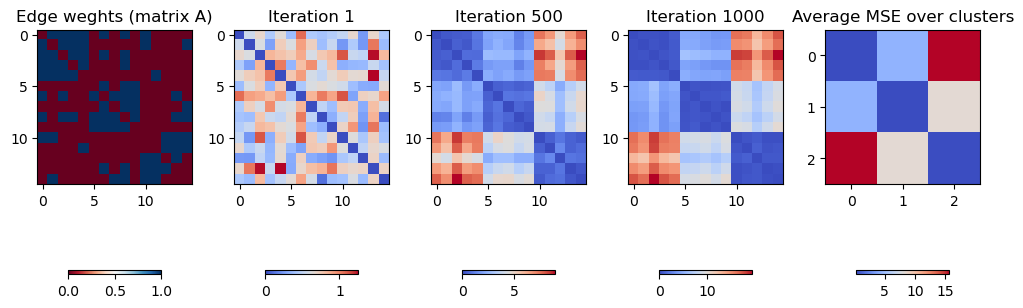

CPU times: user 14 s, sys: 114 ms, total: 14.2 s
Wall time: 7.37 s


In [9]:
%%time
#-----------------Pytorch Linear - no bias-------------------#

# Create linear pytorch models
models = [Linreg_Torch(n_features, bias=False) for i in range(n_clusters*n_ds)]
models_pooled = [Linreg_Torch(n_features, bias=False) for i in range(n_clusters)]

# Build a graph with nodes {model, dataset local, dataset test}
G = build_graph(ds_train, ds_val, ds_shared, models, cluster_labels)
A = build_edges(G, cluster_labels)

G_pooled = build_graph_pooled(ds_train, ds_val, models_pooled, n_clusters=n_clusters)

preds_list, mse_train, mse_val, mse_val_pooled = train(G, A, G_pooled, verbose=False)

fig = plot_preds_similarity(A, preds_list)
fig.tight_layout()
plt.show()

In [10]:
mse_train, mse_val, mse_val_pooled

(array([1.80167802, 1.92545861, 1.52687586, 1.64214121, 1.93659754,
        1.15199078, 1.00643427, 1.29682625, 1.68872223, 1.15700284,
        1.77184829, 2.74356137, 1.72592635, 1.64495822, 1.89786035]),
 array([2.56745036, 2.39955255, 1.92531693, 2.07861332, 2.23981415,
        1.38899577, 1.9860748 , 1.37354231, 1.70713075, 1.50784675,
        1.51390994, 2.55491734, 3.44072635, 2.42695931, 1.75834281]),
 array([2.06615973, 1.96020333, 2.28228538, 1.6784693 , 1.46689167,
        1.70168888, 1.94017312, 1.79272143, 1.52964878, 1.72853795,
        2.46337587, 2.55849819, 3.72910229, 3.26088753, 2.46669927]))

In [11]:
mse_val / mse_val_pooled

array([1.24261949, 1.22413452, 0.84359167, 1.23839817, 1.52691177,
       0.81624543, 1.02365855, 0.76617722, 1.11602792, 0.87232493,
       0.61456717, 0.99860041, 0.92266881, 0.74426342, 0.71283226])

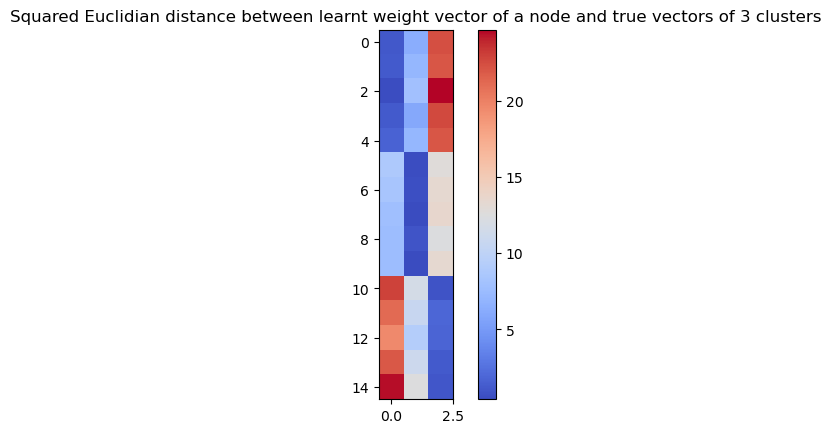

In [12]:
dist = sq_eucl_dist(G, true_weights)
plt.title("Squared Euclidian distance between learnt weight vector of a node and true vectors of 3 clusters")
plt.imshow(dist, cmap="coolwarm")
plt.colorbar()
plt.show()

In [50]:
def kl_divergence(X1, X2):

    """
    Define a function to compute the KL divergence between two multivariate normal distributions.
    """

    mean1, mean2 = X1.mean(axis=0), X2.mean(axis=0)
    cov1, cov2   = np.cov(X1, rowvar=False), np.cov(X2, rowvar=False)

    n = X1.shape[1]

    term_det   = np.log(np.linalg.det(cov2) / np.linalg.det(cov1)) 
    term_trace = np.trace(np.linalg.inv(cov2) @ cov1)
    term_quadr = (mean2 - mean1).T @ np.linalg.inv(cov2) @ (mean2 - mean1)

    return 0.5 * (term_det + term_trace + term_quadr - n)

def build_edges_KL(G, eta=1):
    nn = len(G)
    A = np.zeros((nn, nn))
    rows, cols = A.shape

    for i in range(rows):
        for j in range(cols):
#             if i==j:
#                 A[i,j] = 0
#             else:
                # Get data for nodes i,j
                X1, X2 = G[i]["ds_train"][0], G[j]["ds_train"][0]
                y1, y2 = G[i]["ds_train"][1], G[j]["ds_train"][1]
                
                dist1 = np.hstack((X1, y1))
                dist2 = np.hstack((X2, y2))

                # Compute dist with KL divergence
                kl_dist = np.exp( -(kl_divergence(dist1, dist2) + kl_divergence(dist2, dist1)) )
                print(kl_dist)
                
                # Treshold 
                if kl_dist > eta:
                    A[i,j] = 1
    
    return A

0.9999999999999982
0.16396773033072543
0.12340026166525087
0.25113046206115824
0.17270839955199
2.485174239900636e-12
7.219365372211026e-11
1.9351060083038314e-10
1.7273942759117216e-11
2.0091006818063207e-09
1.4733878174070181e-08
1.532275161181991e-08
1.5061560661606396e-10
5.21671755704031e-10
1.2930736764777017e-11
0.16396773033072543
1.0000000000000036
0.1381737196220366
0.19407696288284038
0.08642897978806494
1.950312954506044e-10
8.255178678394338e-09
1.7286222086073554e-08
3.229874687187519e-09
4.140541530481687e-08
2.4698256033667005e-08
4.0750610916138905e-08
3.176759603154861e-10
1.906670067647173e-09
1.0134881774300666e-10
0.12340026166525087
0.1381737196220366
1.0
0.15391998119231182
0.11325371874269141
2.616943485255122e-12
1.0956919971112898e-10
2.0933834286423152e-10
3.6568643368704754e-11
1.0509871017661551e-09
5.537050199397403e-10
1.0225520020496865e-09
1.2991195427591203e-11
5.840388495226338e-11
1.89305956267887e-12
0.25113046206115824
0.19407696288284038
0.1539199

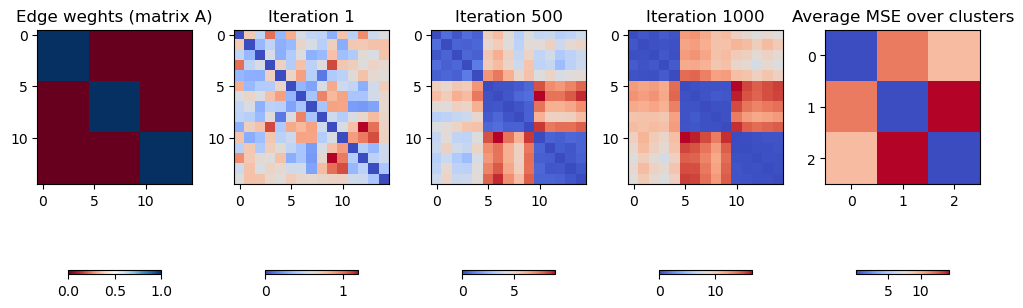

CPU times: user 14.5 s, sys: 141 ms, total: 14.7 s
Wall time: 8.05 s


In [51]:
%%time
#-----------------Pytorch Linear - no bias, with KL divergence-------------------#

# Create linear pytorch models
models = [Linreg_Torch(n_features, bias=False) for i in range(n_clusters*n_ds)]
models_pooled = [Linreg_Torch(n_features, bias=False) for i in range(n_clusters)]

# Build a graph with nodes {model, dataset local, dataset test}
G = build_graph(ds_train, ds_val, ds_shared, models, cluster_labels)
A = build_edges_KL(G, eta=0.07)

G_pooled = build_graph_pooled(ds_train, ds_val, models_pooled, n_clusters=n_clusters)

preds_list, mse_train, mse_val, mse_val_pooled = train(G, A, G_pooled, verbose=False)

fig = plot_preds_similarity(A, preds_list)
fig.tight_layout()
plt.show()

In [ ]:
%%time
#-----------------Pytorch MLP-------------------#

# Create pytorch models
models = [MLP_Torch(n_features) for i in range(n_clusters*n_ds)]
models_pooled = [MLP_Torch(n_features) for i in range(n_clusters)]

# Build a graph with nodes {model, dataset local, dataset test}
G = build_graph(ds_train, ds_val, ds_shared, models, cluster_labels)
A = build_edges(G, cluster_labels)

G_pooled = build_graph_pooled(ds_train, ds_val, models_pooled, n_clusters=n_clusters)

preds_list, mse_train, mse_val, mse_val_pooled = train(G, A, G_pooled, verbose=False)

fig = plot_preds_similarity(A, preds_list)
fig.tight_layout()
plt.show()

In [ ]:
mse_train, mse_val, mse_val_pooled

In [ ]:
mse_val / mse_val_pooled

### Sklearn models

In [ ]:
%%time
#-----------------Sklearn LinReg data augmentation-------------------#

# Create models
models = [Linreg_Sklearn() for i in range(n_clusters*n_ds)]
models_pooled = [Linreg_Sklearn() for i in range(n_clusters)]

# Build a graph with nodes {model, dataset local, dataset test}
G = build_graph(ds_train, ds_val, ds_shared, models, cluster_labels)
A = build_edges(G, cluster_labels)

G_pooled = build_graph_pooled(ds_train, ds_val, models_pooled, n_clusters=n_clusters)

preds_list, mse_train, mse_val, mse_val_pooled = train(G, A, G_pooled, verbose=False)

fig = plot_preds_similarity(A, preds_list)
fig.tight_layout()
plt.show()

In [ ]:
mse_val / mse_val_pooled

In [ ]:
%%time
#-----------------Sklearn DT data augmentation-------------------#

# Create models
models = [DTReg(max_depth=5) for i in range(n_clusters*n_ds)]
models_pooled = [DTReg(max_depth=5) for i in range(n_clusters)]

# Build a graph with nodes {model, dataset local, dataset test}
G = build_graph(ds_train, ds_val, ds_shared, models, cluster_labels)
A = build_edges(G, cluster_labels)

G_pooled = build_graph_pooled(ds_train, ds_val, models_pooled, n_clusters=n_clusters)

preds_list, mse_train, mse_val, mse_val_pooled = train(G, A, G_pooled, verbose=False)

fig = plot_preds_similarity(A, preds_list)
fig.tight_layout()
plt.show()

In [ ]:
mse_train / mse_val_pooled

In [ ]:
mse_val / mse_val_pooled

### Keras models

In [ ]:
%%time
#-----------------Keras MLP data augmentation-------------------#

# Create linear pytorch models
models = [MLP_Keras(n_features) for i in range(n_clusters*n_ds)]
models_pooled = [MLP_Keras(n_features) for i in range(n_clusters)]

# Build a graph with nodes {model, dataset local, dataset test}
G = build_graph(ds_train, ds_val, ds_shared, models, cluster_labels)
A = build_edges(G, cluster_labels)

G_pooled = build_graph_pooled(ds_train, ds_val, models_pooled, n_clusters=n_clusters)

preds_list, mse_train, mse_val, mse_val_pooled = train(G, A, G_pooled, verbose=False)

fig = plot_preds_similarity(A, preds_list)
fig.tight_layout()
plt.show()

In [ ]:
mse_train / mse_val_pooled

In [ ]:
mse_val / mse_val_pooled

# Effect of regularization term $\lambda$ on loss and sample size of a local dataset

In [ ]:
plt.style.use('ggplot')

In [ ]:
def iter_params(config, compute_dist=False):
    
    """
    :param config: dictionary containing necessary parameters.
    :param compute_dist: if True returns computed output `dist_list`, otherwise returns list with zero arrays. Set True only for linear models without bias term.
    
    Number of hyperparameters' combinations is k = len(reg_term_list)*len(n_samples_list)
    
    :out nodes_preds_list:    list with k elements. Each element is an array of shape (repeat_times, m_shared, n_nodes) containing predictions on shared ds from repeat_times runs for each node in the graph. 
    :out mse_train_list:      list with k elements. Each element is an array of shape (repeat_times, n_nodes) containing training loss for repeat_times runs for each node in the graph. 
    :out mse_val_list:        list with k elements. Each element is an array of shape (repeat_times, n_nodes) containing validation loss for repeat_times runs for each node in the graph. 
    :out mse_val_pooled_list: list with k elements. Each element is an array of shape (repeat_times, n_nodes) containing validation loss for repeat_times runs for each cluster model on the local nodes val ds. 
    :out dist_list:           list with k elements. Each element is an array of shape (repeat_times, n_nodes, n_clusters) containing squared L2 distance loss between learnt weight vector and 'true' weight vector for each cluster (i.e. weight vector used for data generation). 
    """
    
    # Config
    n_clusters    = config['n_clusters']
    n_ds          = config['n_ds']
    n_features    = config['n_features']
    noise_val     = config['noise_val']
    
    p_in          = config['p_in']
    p_out         = config['p_out']
    
    reg_term_list  = config['reg_term_list']
    n_samples_list = config['n_samples_list']
    repeat_times   = config['repeat_times']
    
    models         = config['models']
    models_pooled  = config['models_pooled']
    
    file_name      = config['file_name']

    m_shared       = 100
    n_nodes        = n_clusters * n_ds
    
    # Lists to store results of train() loop with hyperparams pairs {reg_term,n_samples} repeated `repeat_times` times
    mse_train_list      = []  # mse loss on local training ds
    mse_val_list        = []  # mse loss on local validation ds
    mse_val_pooled_list = []  # mse loss on pooled (for each cluster) validation ds
    nodes_preds_list    = []  # preds on shared ds
    dist_list           = []  # squared L2 distance between learnt and `true` weight vectors
    
    # Create dir to save results of the experiment
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    path = '../out/' + file_name + '_' + timestamp
    os.mkdir(path)

    for reg_term in reg_term_list:
        for n_samples in tqdm(n_samples_list):
            # Arrays to store intermediate results
            mse_train_array      = np.zeros((repeat_times, n_nodes))
            mse_val_array        = np.zeros((repeat_times, n_nodes))
            mse_val_pooled_array = np.zeros((repeat_times, n_nodes))
            nodes_preds_array    = np.zeros((repeat_times, m_shared, n_nodes))
            dist_array           = np.zeros((repeat_times, n_nodes, n_clusters))
            
            # Repeat train() with hyperparams {reg_term, n_samples} 
            for i in range(repeat_times):
                # Create a dataset
                ds_train, ds_val, cluster_labels, true_weights = get_data(n_clusters, n_ds, n_samples, n_features, noise_val)
                ds_shared = get_shared_data(m_shared, n_features)
                
                # Build a graph with nodes {model, dataset local, dataset test}
                G = build_graph(ds_train, ds_val, ds_shared, deepcopy(models), cluster_labels)
                A = build_edges(G, cluster_labels, p_in = p_in, p_out = p_out)
                G_pooled = build_graph_pooled(ds_train, ds_val, models_pooled, n_clusters=n_clusters)
                preds_list, mse_train, mse_val, mse_val_pooled = train(G, A, G_pooled, regularizer_term=reg_term, verbose=False)

                # Save preds on a shared set of last iteration
                nodes_preds_array[i] = preds_list[-1] 
                # Save mse on a local ds
                mse_train_array[i] = mse_train
                mse_val_array[i] = mse_val
                mse_val_pooled_array[i] = mse_val_pooled
                if compute_dist:
                    # only for G with lin.models (no bias)
                    # compute dist b/learnt model's weight vector and true weight vector for each cluster 
                    dist = sq_eucl_dist(G, true_weights)
                    dist_array[i] = dist
            
            data_to_save = {
            'repeat_times': repeat_times,
            'n_nodes': n_nodes,
            'n_clusters': n_clusters,
            'n_ds': n_ds,
            'n_features': n_features,
            'n_samples': n_samples, 
            'n_samples_shared': m_shared, 
            'noise_val': noise_val,
            'reg_term': reg_term,
            'p_in': p_in,
            'p_out': p_out,
            'models': str(models),
            'models_pooled': str(models_pooled)
            }
            
            # Create subdir to save experiment with current reg_term and n_ds values
            subdir = path + '/' + 'reg_term_' + str(reg_term) + '_n_samples_' + str(n_samples)
            os.mkdir(subdir)
            
            config_path = subdir + '/config_' + timestamp + '.json'
            with open(config_path, 'w') as f:
                json.dump(data_to_save, f, indent=2)
                
            np.save(subdir + '/mse_train'     + '_' + timestamp + '.npy', mse_train_array)
            np.save(subdir + '/mse_val'       + '_' + timestamp + '.npy', mse_val_array)
            np.save(subdir + '/mse_val_pooled'+ '_' + timestamp + '.npy', mse_val_pooled_array)
                
            mse_train_list.append(mse_train_array)
            mse_val_list.append(mse_val_array)
            mse_val_pooled_list.append(mse_val_pooled_array)
            nodes_preds_list.append(nodes_preds_array)
            dist_list.append(dist_array) 
            
    return nodes_preds_list, mse_train_list, mse_val_list, mse_val_pooled_list, dist_list

### Predictions 

In [ ]:
def mse_mean_std(mse_local_list):
    """
    Average mse values for each node over repeatitions (`repeat_times` param)
    """
    mse_local_mean = []
    mse_local_std = []

    for mse_local in mse_local_list:
        mse_local_mean.append(np.mean(mse_local))
        # first average mse across nodes, then compute std across `repeat_times` (i.e. number of runs)
        std = np.std(np.mean(mse_local, axis=1))
        mse_local_std.append(std)

    return mse_local_mean, mse_local_std

In [ ]:
def mse_mean_std_scaled(mse_list, mse_pooled_list):
    
    """
    :param mse_list: list with k elements. Each element is an array of shape (repeat_times, n_nodes) containing training loss for repeat_times runs for each node in the graph. 
    :param mse_pooled_list: list with k elements. Each element is an array of shape (repeat_times, n_nodes) containing validation loss for repeat_times runs for each cluster model on the local node's val ds. 

    Average mse values for each node over repeatitions (`repeat_times` param)
    """
    
    n_clusters = mse_pooled_list[0].shape[1]
    n_nodes    = mse_list[0].shape[1]
    n_ds       = int(n_nodes / n_clusters) 
    
    mse_mean = []
    mse_std = []

    for mse, mse_pooled in zip(mse_list, mse_pooled_list):
        
        mse_scaled = mse / mse_pooled
        std = np.std(np.mean(mse_scaled, axis=1))
        
        mse_mean.append(np.mean(mse_scaled))
        mse_std.append(std)

    return mse_mean, mse_std

### Weight vectors dist - only for pytorch lin.model (set bias=False)

In [ ]:
def cluster_dist(dist):
    """
    For a set of nodes belonging to one cluster compute mean (squared) Euclidian distance:
    dist_in  - mean dist between true weight vector of a cluster c to which nodes belong to and weight vector learnt by the model.
    dist_out - same but, for other than c clusters.
    Finally, all dist_in, dist_out values are averaged. 
    :param dist: shape (n_nodes, n_clusters)
    Output is a tuple, where each element is a float number.
    """
    # for each set of nodes (from one cluster) compute mean dist with weight vector of cluster_in, cluster_out
    # store in these lists
    dist_in = []
    dist_out = []
    n_clusters = dist.shape[1]
    n_ds = int(dist.shape[0]/n_clusters)
    
    cluster_labels = []
    for i in range(n_clusters):
        cluster_labels = cluster_labels + n_ds*[i] 
    
    for c in range(n_clusters):
        # Array of clusters
        clusters = np.array(range(n_clusters))
        # Clusters which are different from current cluster c
        clusters_out = np.where(clusters!=c)
        # Indices of nodes belonging to a cluster c
        node_ind = np.where(np.array(cluster_labels)==c)
        # Mean dist within cluster
        dist_in.append(np.mean(dist[node_ind, c]))
        # Mean dist out of cluster
        dist_out.append(np.mean(dist[node_ind,:][:,:,clusters_out]))
    return np.mean(dist_in),  np.mean(dist_out)

def cluster_dist_mean(dist_list):
    """
    Average 
    :param dist_list: list of len=len(reg_term_list)*len(n_samples_list). 
    Each element of the list is of shape (repeat_times, n_nodes, n_clusters)
    """
    dist_in_mean = []
    dist_out_mean = []

    for dist in dist_list:
        dist_in_list = []
        dist_out_list = []
        for e in dist:
            # for each repetition (`repeat_times`) compute dist (float numbers)
            dist_in, dist_out = cluster_dist(e)
            dist_in_list.append(dist_in)
            dist_out_list.append(dist_out)
        # compute mean across repetitions
        dist_in_mean.append(np.mean(dist_in_list))
        dist_out_mean.append(np.mean(dist_out_list))
    return dist_in_mean, dist_out_mean

In [ ]:
def plot_cluster_dist(cluster_dist, reg_term_list, n_samples_list):
    
    n_regs = len(reg_term_list)
    n_sizes = len(n_samples_list)
    titles = ['Learnt w vs true w of a cluster_in', 'Learnt w vs true w of clusters_out']
    
    fig, axes = plt.subplots(1,2, sharey=True, figsize=(10,4))

    for j in range(2):
        for i in range(n_regs):
            axes[j].plot(n_samples_list, cluster_dist[j][i*n_sizes:i*n_sizes+n_sizes], label='Regularization term ' + str(reg_term_list[i]))

        axes[j].set_title(titles[j])
        axes[j].set_xlabel('Local dataset size')
        axes[j].set_ylabel('Sq.Euclidian distance')
        axes[j].set_xticks(n_samples_list)
        axes[j].legend()
    plt.show()

In [ ]:
def plot_mse(mse_mean, mse_std, reg_term_list, n_samples_list):
    """
    """
    
    n_regs = len(reg_term_list)
    n_sizes = len(n_samples_list)
    
    for i in range(n_regs):
        y = mse_mean[i*n_sizes:i*n_sizes+n_sizes]
        y_err = mse_std[i*n_sizes:i*n_sizes+n_sizes]
        ax.errorbar(n_samples_list, y, yerr=y_err, label='Reg. term ' + str(reg_term_list[i]), lolims=True, linestyle='--')

    ax.set_xticks(n_samples_list)
    return ax

In [ ]:
# Hyperparameters to try:

# sample size of a local dataset at each node
n_samples_list = [5, 10, 20, 30, 50, 100]
# value of regularization term lambda
reg_term_list = [0, 0.01, 0.1]
# repeat experiment number of times
repeat_times = 10
# noise scale for synthetic data
noise_val = 1.0
# prob of edges
p_in, p_out = 0.8, 0.2

# Config
config = {}

n_clusters, n_ds, n_features = 3, 5, 10

config['reg_term_list']  = reg_term_list
config['n_samples_list'] = n_samples_list
config['repeat_times']   = repeat_times 
config['noise_val']      = noise_val

config['n_clusters']     = n_clusters 
config['n_ds']           = n_ds 
config['n_features']     = n_features
config['p_in']           = p_in
config['p_out']          = p_out

## All models in a Graph are of one type

### Pytorch Linreg

In [ ]:
%%time
#-----------------Pytorch Linear-------------------#

# Create linear pytorch models
models = [Linreg_Torch(n_features, bias=False) for i in range(n_clusters*n_ds)]
models_pooled = [Linreg_Torch(n_features, bias=False) for i in range(n_clusters)]
    
config['models'] = models
config['models_pooled'] = models_pooled
config['noise_val'] = 1
config['file_name'] = 'Linreg_Torch'

nodes_preds, mse_train, mse_val, mse_val_pooled, dist = iter_params(config, compute_dist=True)

In [ ]:
# Average results of repeated experiments
cdm = cluster_dist_mean(dist)

plot_cluster_dist(cdm, reg_term_list, n_samples_list)

In [ ]:
# Plot raw mse vals
mse_t, mse_std_t = mse_mean_std(mse_train)
mse_v, mse_std_v = mse_mean_std(mse_val)

mse = [ [(mse_t, mse_std_t), (mse_v, mse_std_v)] ]

titles = ['Train ds', 'Validation ds']

fig, axs = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(8,3))

for i in range(1):
    plot_list = mse[i]

    for ax, data, title in zip(axs, plot_list, titles):
        mse = data[0]
        mse_std = data[1]
        plot_mse(mse, mse_std, reg_term_list, n_samples_list)
        ax.set_title(title)

axs[0].set_ylabel ('MSE')
axs[0].set_xlabel ('Training ds size')
axs[1].set_xlabel ('Training ds size')

plt.legend()
fig.tight_layout()
plt.show()

In [ ]:
# Plot mse scaled by mse of the 'pooled' mmodels on pooled validation ds
mse_t, mse_std_t = mse_mean_std_scaled(mse_train, mse_val_pooled)
mse_v, mse_std_v = mse_mean_std_scaled(mse_val, mse_val_pooled)

mse = [ [(mse_t, mse_std_t), (mse_v, mse_std_v)] ]

titles = ['Train ds', 'Validation ds']

fig, axs = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(8,3))

for i in range(1):
    plot_list = mse[i]

    for ax, data, title in zip(axs, plot_list, titles):
        mse = data[0]
        mse_std = data[1]
        plot_mse(mse, mse_std, reg_term_list, n_samples_list)
        ax.set_title(title)

axs[0].set_ylabel ('MSE')
axs[0].set_xlabel ('Training ds size')
axs[1].set_xlabel ('Training ds size')

plt.ylim(0,6)
plt.legend()
fig.tight_layout()
plt.show()

In [ ]:
%%time
#-----------------Pytorch Linear-------------------#

lrates = [0.001, 0.01, 0.1]
mse_lrates = []
mse_lrates_scaled = []

for lrate in lrates:
    # Create linear pytorch models
    models = [Linreg_Torch(n_features, lr=lrate) for i in range(n_clusters*n_ds)]
    models_pooled = [Linreg_Torch(n_features, lr=lrate) for i in range(n_clusters)]
    
    config['models'] = models
    config['models_pooled'] = models_pooled
    config['noise_val'] = 1
    config['file_name'] = 'Linreg_Torch_lrate_' + str(lrate)
    
    nodes_preds, mse_train, mse_val, mse_val_pooled, dist = iter_params(config)
    
    mse_t, mse_std_t = mse_mean_std(mse_train)
    mse_v, mse_std_v = mse_mean_std(mse_val)
    
    mse_t_scaled, mse_std_t_scaled = mse_mean_std_scaled(mse_train, mse_val_pooled)
    mse_v_scaled, mse_std_v_scaled = mse_mean_std_scaled(mse_val, mse_val_pooled)
    
    mse_lrates.append( [(mse_t, mse_std_t), (mse_v, mse_std_v)] )
    mse_lrates_scaled.append( [(mse_t_scaled, mse_std_t_scaled), (mse_v_scaled, mse_std_v_scaled)] )

In [ ]:
import json

with open('../out/linreg_syn_ds_lrate.json', 'w') as f:
    json.dump(mse_lrates, f)
with open('../out/linreg_syn_ds_lrate_scaled.json', 'w') as f:
    json.dump(mse_lrates_scaled, f)

In [ ]:
titles = ['Train ds', 'Validation ds']

fig, axes = plt.subplots(len(lrates), 2, sharey=True, sharex=True, figsize=(8,8))

for i in range(len(lrates)):
    plot_list = mse_lrates[i]
    axs = axes[i]

    for ax, data, title in zip(axs, plot_list, titles):
        mse = data[0]
        mse_std = data[1]
        plot_mse(mse, mse_std, reg_term_list, n_samples_list)
        ax.set_title(title + ' lrate = ' + str(lrates[i]))

axes[0,0].set_ylabel ('MSE')
axes[1,0].set_ylabel ('MSE')
axes[2,0].set_ylabel ('MSE')

axes[-1,0].set_xlabel ('Training ds size')
axes[-1,1].set_xlabel ('Training ds size')
plt.legend()
fig.tight_layout()
plt.savefig("../out/linreg_syn_lrate.png")
plt.show()

In [ ]:
titles = ['Train ds', 'Validation ds']

fig, axes = plt.subplots(len(lrates), 2, sharey=True, sharex=True, figsize=(8,8))

for i in range(len(lrates)):
    plot_list = mse_lrates_scaled[i]
    axs = axes[i]

    for ax, data, title in zip(axs, plot_list, titles):
        mse = data[0]
        mse_std = data[1]
        plot_mse(mse, mse_std, reg_term_list, n_samples_list)
        ax.set_title(title + ' lrate = ' + str(lrates[i]))
        ax.axhline(y=1, xmin=0, xmax=100, lw=0.5, c='k', ls='--')

axes[0,0].set_ylabel ('MSE')
axes[1,0].set_ylabel ('MSE')
axes[2,0].set_ylabel ('MSE')

axes[-1,0].set_xlabel ('Training ds size')
axes[-1,1].set_xlabel ('Training ds size')
plt.legend()
fig.tight_layout()
plt.savefig("../out/linreg_syn_lrate_scaled.png")
plt.show()

In [ ]:
%%time
#-----------------Pytorch Linear data augmentation-------------------#

lrates = [0.001, 0.01, 0.1]
mse_lrates_aug = []

for lrate in lrates:
    # Create linear pytorch models
    models = [Linreg_Torch_aug(n_features, lr=lrate) for i in range(n_clusters*n_ds)]
    models_pooled = [Linreg_Torch_aug(n_features, lr=lrate) for i in range(n_clusters)]
    
    config['models'] = models
    config['models_pooled'] = models_pooled
    config['noise_val'] = 1
    config['file_name'] = 'Linreg_Torch_aug_lrate_' + str(lrate)
    
    nodes_preds, mse_train, mse_val, mse_val_pooled, dist = iter_params(config)
    
    mse_train, mse_std_train = mse_local_mean(mse_train_list)
    mse_val, mse_std_val = mse_local_mean(mse_val_list)
    
    mse_lrates_aug.append( [(mse_train, mse_std_train), (mse_val, mse_std_val)] )

In [ ]:
import json

with open('linreg_aug_syn_ds_lrate.json', 'w') as f:
    json.dump(mse_lrates, f)

In [ ]:
titles = ['Train ds', 'Validation ds']

fig, axes = plt.subplots(len(lrates), 2, sharey=True, sharex=True, figsize=(8,8))

for i in range(len(lrates)):
    plot_list = mse_lrates[i]
    axs = axes[i]

    for ax, data, title in zip(axs, plot_list, titles):
        mse = data[0]
        mse_std = data[1]
        plot_mse(mse, mse_std, reg_term_list, n_samples_list)
        ax.set_title(title + ' lrate = ' + str(lrates[i]))

axes[0,0].set_ylabel ('MSE')
axes[1,0].set_ylabel ('MSE')
axes[2,0].set_ylabel ('MSE')

axes[-1,0].set_xlabel ('Local dataset size')
axes[-1,1].set_xlabel ('Local dataset size')
plt.legend()
fig.tight_layout()
plt.savefig("linreg_aug_syn_ds_lrate_.png")
plt.show()

### Pytorch - MLP

In [ ]:
%%time
#-----------------Pytorch Linear data augmentation-------------------#
   
# Create linear pytorch models
models = [Linreg_Torch_aug(n_features) for i in range(n_clusters*n_ds)]
config['models'] = models

pred_test_list, mse_local_list, dist_list = iter_params(config)

# Plot MSE
mse, mse_std = mse_local_mean(mse_local_list)
plot_mse(mse, mse_std, reg_term_list, n_samples_list)

### Sklearn

In [ ]:
%%time
#-----------------Sklearn LinReg-------------------#
   
# Create linear pytorch models
models = [Linreg_Sklearn() for i in range(n_clusters*n_ds)]
config['models'] = models
config['noise_val'] = 1

nodes_preds_list, mse_train_list, mse_val_list, dist_list = iter_params(config)

mse_train, mse_std_train = mse_local_mean(mse_train_list)
mse_val, mse_std_val = mse_local_mean(mse_val_list)

In [ ]:
titles = ['Train ds', 'Validation ds']

fig, axes = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(8,4))

for ax, data, title in zip(axes, [(mse_train, mse_std_train), (mse_val, mse_std_val )], titles):
    mse = data[0]
    mse_std = data[1]
    plot_mse(mse, mse_std, reg_term_list, n_samples_list)
    ax.set_title(title)

# axes[0,0].set_ylabel ('MSE')
# axes[1,0].set_ylabel ('MSE')
# axes[2,0].set_ylabel ('MSE')

# axes[-1,0].set_xlabel ('Local dataset size')
# axes[-1,1].set_xlabel ('Local dataset size')
plt.legend()
fig.tight_layout()
plt.savefig("sklearn_linreg_syn_ds_lrate.png")
plt.show()

In [ ]:
%%time
#-----------------DT-------------------#

# Create linear pytorch models
models = [DTReg() for i in range(n_clusters*n_ds)]
config['models'] = models
config['noise_val'] = 1

nodes_preds_list, mse_train_list, mse_val_list, dist_list = iter_params(config)
mse_train, mse_std_train = mse_local_mean(mse_train_list)
mse_val, mse_std_val = mse_local_mean(mse_val_list)

In [ ]:
titles = ['Train ds', 'Validation ds']

fig, axes = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(8,4))

for ax, data, title in zip(axes, [(mse_train, mse_std_train), (mse_val, mse_std_val )], titles):
    mse = data[0]
    mse_std = data[1]
    plot_mse(mse, mse_std, reg_term_list, n_samples_list)
    ax.set_title(title)

# axes[0,0].set_ylabel ('MSE')
# axes[1,0].set_ylabel ('MSE')
# axes[2,0].set_ylabel ('MSE')

# axes[-1,0].set_xlabel ('Local dataset size')
# axes[-1,1].set_xlabel ('Local dataset size')
plt.legend()
fig.tight_layout()
plt.savefig("DT_syn_ds_lrate.png")
plt.show()

In [ ]:
%%time
#-----------------DT-------------------#

noise_vals = [0, 0.5, 1]
mse_noise = []

for noise_val in noise_vals:
    # Create linear pytorch models
    models = [DTReg(max_depth=3) for i in range(n_clusters*n_ds)]
    config['models'] = models
    config['noise_val'] = noise_val
    
    nodes_preds_list, mse_train_list, mse_val_list, dist_list = iter_params(config)
    mse_train, mse_std_train = mse_local_mean(mse_train_list)
    mse_val, mse_std_val = mse_local_mean(mse_val_list)
    
    mse_noise.append( [(mse_train, mse_std_train), (mse_val, mse_std_val)] )

In [ ]:
titles = ['MSE on a train dataset', 'MSE on a val dataset']

fig, axes = plt.subplots(len(noise_vals), 2, sharey=True, sharex=True, figsize=(8,8))

for i in range(len(noise_vals)):
    plot_list = mse_noise[i]
    axs = axes[i]

    for ax, data, title in zip(axs, plot_list, titles):
        mse = data[0]
        mse_std = data[1]
        plot_mse(mse, mse_std, reg_term_list, n_samples_list)
        ax.set_title(title + ' noise = ' + str(noise_vals[i]))

axes[0,0].set_ylabel ('MSE')
axes[1,0].set_ylabel ('MSE')
axes[2,0].set_ylabel ('MSE')

axes[-1,0].set_xlabel ('Local dataset size')
axes[-1,1].set_xlabel ('Local dataset size')
plt.legend()
fig.tight_layout()
plt.savefig("DT_syn_ds.png")
plt.show()

In [ ]:
titles = ['Train dataset', 'Val dataset']

fig, axes = plt.subplots(len(lrates), 2, sharey=True, sharex=True, figsize=(8,8))

for i in range(len(lrates)):
    plot_list = mse_lrates[i]
    axs = axes[i]

    for ax, data, title in zip(axs, plot_list, titles):
        mse = data[0]
        mse_std = data[1]
        plot_mse(mse, mse_std, reg_term_list, n_samples_list)
        ax.set_title(title + ', max depth = ' + str(max_depths[i]))

axes[-1,0].set_xlabel ('Training ds size')
axes[-1,1].set_xlabel ('Training ds size')
plt.legend()
fig.tight_layout()
plt.savefig("DT_toy_ds.png")
plt.show()

## Models in a Graph are of one type within a cluster

### Pytorch Linreg + DT

- Cluster 1 -  Pytorch Linreg
- Cluster 2 -  DT
- Cluster 3 -  Pytorch Linreg

Learning rate for Pytorch models = 0.01

In [ ]:
%%time
#-----------------Mix [pytorch linreg, DT, pytorch linreg] max depth-------------------# 

max_depth = [5, 10]
mse_max_depth = []
mse_max_depth_scaled = []

for max_d in max_depth:
    # Create models
    models = [Linreg_Torch(n_features, lr=0.01) for i in range(n_ds)] + [DTReg(max_depth=max_d) for i in range(n_ds)] + [Linreg_Torch(n_features, lr=0.01) for i in range(n_ds)]
    models_pooled = [Linreg_Torch(n_features, lr=0.01), DTReg(max_depth=max_d), Linreg_Torch(n_features, lr=0.01)]
    config['models'] = models
    config['models_pooled'] = models_pooled
    config['noise_val'] = 1
    config['file_name'] = 'Linreg_Torch_DT_max_depth_' + str(max_depth)
    
    nodes_preds, mse_train, mse_val, mse_val_pooled, dist = iter_params(config)
    mse_t, mse_std_t = mse_mean_std(mse_train)
    mse_v, mse_std_v = mse_mean_std(mse_val)
    
    mse_t_scaled, mse_std_t_scaled = mse_mean_std_scaled(mse_train, mse_val_pooled)
    mse_v_scaled, mse_std_v_scaled = mse_mean_std_scaled(mse_val, mse_val_pooled)
    
    mse_max_depth.append( [(mse_t, mse_std_t), (mse_v, mse_std_v)] )
    mse_max_depth_scaled.append( [(mse_t_scaled, mse_std_t_scaled), (mse_v_scaled, mse_std_v_scaled)] )

In [ ]:
with open('linreg_DT_linreg_syn_max_depth.json', 'w') as f:
    json.dump(mse_max_depth, f)
    
with open('linreg_DT_linreg_syn_max_depth_scaled.json', 'w') as f:
    json.dump(mse_max_depth_scaled, f)

In [ ]:
titles = ['Train dataset', 'Val dataset']

fig, axes = plt.subplots(len(max_depth), 2, sharey=True, sharex=True, figsize=(8,6))

for i in range(len(max_depth)):
    plot_list = mse_max_depth[i]
    axs = axes[i]

    for ax, data, title in zip(axs, plot_list, titles):
        mse = data[0]
        mse_std = data[1]
        plot_mse(mse, mse_std, reg_term_list, n_samples_list)
        ax.set_title(title + ' DT max_depth = ' + str(max_depth[i]))

axes[0,0].set_ylabel ('Loss')
axes[1,0].set_ylabel ('Loss')

axes[-1,0].set_xlabel ('Training ds size')
axes[-1,1].set_xlabel ('Training ds size')
plt.legend()
fig.tight_layout()
plt.savefig("linreg_DT_linreg_syn_max_depth.png")
plt.show()

In [ ]:
titles = ['Train dataset', 'Val dataset']

fig, axes = plt.subplots(len(max_depth), 2, sharey=True, sharex=True, figsize=(8,6))

for i in range(len(max_depth)):
    plot_list = mse_max_depth_scaled[i]
    axs = axes[i]

    for ax, data, title in zip(axs, plot_list, titles):
        mse = data[0]
        mse_std = data[1]
        plot_mse(mse, mse_std, reg_term_list, n_samples_list)
        ax.set_title(title + ' DT max_depth = ' + str(max_depth[i]))
        ax.axhline(y=1, xmin=0, xmax=100, lw=0.5, c='k', ls='--')

axes[0,0].set_ylabel ('Scaled loss')
axes[1,0].set_ylabel ('Scaled loss')

axes[-1,0].set_xlabel ('Training ds size')
axes[-1,1].set_xlabel ('Training ds size')
plt.legend()
fig.tight_layout()
plt.savefig("linreg_DT_linreg_syn_max_depth_scaled.png")
plt.show()